# TP9 - Recursive Neural Networks (RNN) Exercises
##### Duarte Balata(46304) Miguel Oliveira (55772)

Below we will begin by following the **tutorial** provided on section 3.3 to train a RNN to make predictions of a time-series.

In [109]:
# lstm for time series forecasting
import matplotlib.pyplot as plt
import pandas as pd
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [110]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Split Function and Train Test Split
As per the tutorial , we used the split_sequence function provided. This function will restructure the univariate time series data that will be used into a format that is suitable to be fitted into a supervised learning model. As per the tutorial, we will use the supervised Long Short-Term Memory Network model. The data below is structured so that each sequence can predict an output.

The number of outputs predicted can be modifed via ***n_predictied***. The window size, which accounts for the number of values in each sequence that is split can be specified via ***window_size***

For now, data is split into train and test - the data will also be split into validation later on the exercise.

In [111]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out=1):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return asarray(X), asarray(y)
 
def prepare_data(values, window_size=5, n_predicted=1, n_val=12, n_test=0):
  # specify the window size
  # split into samples
  X, y = split_sequence(values, window_size, n_predicted)
  # reshape into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], 1))
  # split into train/test
  n_train = len(X) - n_val - n_test
  X_train, X_val, X_test, y_train, y_val, y_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:], y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]
  print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

  return X_train, X_val, X_test, y_train, y_val, y_test, window_size

### Loading the Dataset
The data that is used to train the RNN model is a univariate time-series dataset that accounts for the monthly car sales in Quebec throughout 1960-1968.

In [112]:
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0, index_col=0, squeeze=True)
# retrieve the values
values = df.values.astype('float32')

As per the tutorial on Section 3.3 we will use a window each containing 5 consecutive months and the output will be only 1 (the following month). The data will be split into train and test. Below, we will set x_test to have 12 windows, each with an output of 1 which will be y_test. 

In [113]:
X_train, X_val, X_test, y_train, y_val, y_test, n_steps = prepare_data(values, n_val=12, n_test=12)

(79, 5, 1) (12, 5, 1) (12, 5, 1) (79, 1) (12, 1) (12, 1)


### Creating the model
Below, we will use the base model provided in the tutorial however , we will add a pre-processing stage with normalization and also the option to add batch normalization, dropout and early stop. 

These will be set to true or false as we experiment and discuss the impact on the performance of the model.

In addition, we will also split the data into test train and validation so we can properly use the options described above and evaluate the model.

We also include the metrics to evaluate the model - Mean Squared Error, Mean Absolute Error and Root Mean Squared Error , which will record the average of these values after running the model 5 times.

In [114]:
def create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=1, normalize=False, dropout=False, batch_norm=False, early_stop=False, metrics=False, dropout_val=0.2, patience=50):

  if normalize == True:
    X_mean = X_train.mean()
    X_std = X_train.std()

    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std
    
    y_train = (y_train - X_mean) / X_std
    y_val = (y_val - X_mean) / X_std
    y_test = (y_test - X_mean) / X_std

  results = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE'])

  
  for i in range(5):
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
    
    if dropout == True:
        model.add(Dropout(dropout_val))
    if batch_norm == True:
        model.add(BatchNormalization())

    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))

    if dropout == True:
        model.add(Dropout(dropout_val))
    if batch_norm == True:
        model.add(BatchNormalization())

    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
        
    model.add(Dense(n_predicted))
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=patience)
        
        
    # fit the model
    if early_stop == True:
        history = model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    else:
        history = model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0, validation_data=(X_val, y_val))
    # evaluate the model
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
            
    results.loc[i,'MSE'] = mse 
    results.loc[i,'RMSE'] = sqrt(mse)
    results.loc[i,'MAE'] = mae

  print('Average MSE: %.3f, Average  RMSE: %.3f, Average MAE: %.3f' % (results["MSE"].mean(), sqrt(results["MSE"].mean()), results["MAE"].mean()))

  if metrics == True:
    return history, results["MSE"].mean(), sqrt(results["MSE"].mean()), results["MAE"].mean()

  return model, history

We will now fit and train the base model - as per the tutorial. Below we obtain the average metrics after running the model 5 times.

In [115]:
model_base, history_base = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps)

Average MSE: 12009785.600, Average  RMSE: 3465.514, Average MAE: 2814.902


The metrics above account for a very high value for the average MSE - this can be due to the fact this error is squared. Nevertheless, we also see significant high numbers for RMSE and MAE. As we experiment further we will compare the results obtained in the following exercises to try to interpret the meaning of these values. Below we make a prediction based on the base model - please note we will discuss these further on the exercises below.

In [116]:
# make a prediction
row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0]).reshape((1, n_steps, 1))
yhat = model_base.predict(row)
print('Predicted: %.3f' % (yhat))

Predicted: 16876.236


## 6 month training window

Below we will now increase the windows size of 5 to 6 months. Please note, all other paramenters will remain the as per the base model.

In [117]:
X_train, X_val, X_test, y_train, y_val, y_test, n_steps = prepare_data(values, window_size=6, n_val=12, n_test=12);

(78, 6, 1) (12, 6, 1) (12, 6, 1) (78, 1) (12, 1) (12, 1)


In [118]:
model_6months, history_6months = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps)

Average MSE: 11282647.800, Average  RMSE: 3358.965, Average MAE: 2689.701


We can see a very slight improvement in the performance of the model - it is not very significant however, it does make sense that the model performs a bit better once the window size is increase to more months as the model is able to learn from a bigger sized sample.

Below we will define the metrics that will be used to plot the learning curves to present the results.

In [119]:
def plot_metric(axis, history_n, metric="mae", title= "Learning Curves"):
  axis.set_title(title)
  axis.set_xlabel('Epoch')
  axis.set_ylabel(metric)
  axis.plot(history_n.history[metric], label='train')
  axis.plot(history_n.history['val_'+metric], label='validation')
  axis.legend()

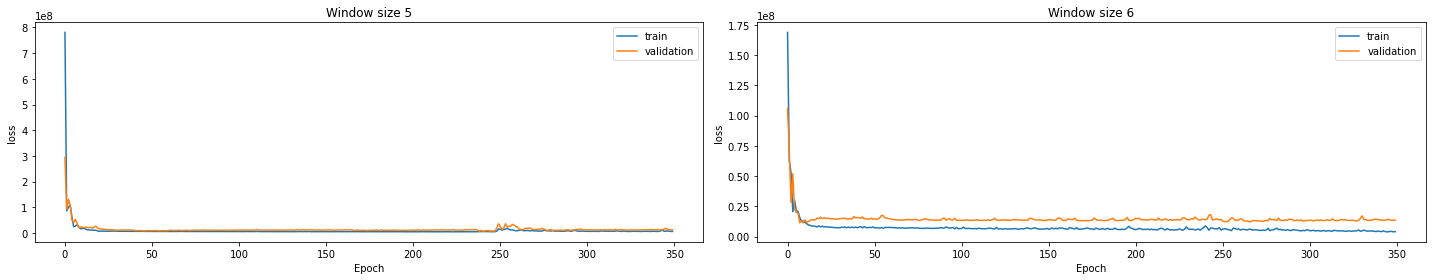

In [120]:
# plot learning curves
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 4))
plot_metric(ax1, history_base, metric="loss", title="Window size 5")
plot_metric(ax2, history_6months, metric="loss", title="Window size 6")
plt.tight_layout()

Based on the behaviour of 5 runs -  we can see that with a **window size of 5** we can observe a good fit learning curve. Both Train and Validation settle early before 50 epoch and stabilize. The distance between each other is minimal - suggesting a good fit. 

On the other hand, a **window size of 6** based on the observation above shows signs of an unrepresentative training dataset. The validation and train lines follow a similar trend, however the distance between them suggests that the training data as fewer examples to learn from than the validation data. 

## Normalization + dropout + batch normalization + early stopping.

In this section, we will experiment with normalization pre-processing, dropout , batch normalization and early stopping - we will use the model previously defined and set as *True* when using the required parameter. We will then compare the values by using a plotted graph showing the loss of the train and validation sets.

In [104]:
X_train, X_val, X_test, y_train, y_val, y_test, n_steps = prepare_data(values, window_size=6, n_val=12, n_test=12);

(78, 6, 1) (12, 6, 1) (12, 6, 1) (78, 1) (12, 1) (12, 1)


In [105]:
print("Base:")
model_6_base, history_6_base = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps)
print("Normalized:")
model_6_norm, history_6_norm = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, normalize=True)
print("Dropout:")
model_6_dropout, history_6_dropout = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, dropout=True)
print("Batch Normalization:")
model_6_batch_norm, history_6_batch_norm = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, batch_norm=True)
print("Early Stop:")
model_6_early_stop, history_6_early_stop = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, early_stop=True)
print("All changes:")
model_6_all, history_6_all = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, normalize=True, dropout=True, batch_norm=True, early_stop=True)

Base:
Average MSE: 12353051.800, Average  RMSE: 3514.691, Average MAE: 2753.631
Normalized:
Average MSE: 0.600, Average  RMSE: 0.775, Average MAE: 0.609
Dropout:
Average MSE: 46894203.200, Average  RMSE: 6847.934, Average MAE: 5931.645
Batch Normalization:
Average MSE: 96597056.000, Average  RMSE: 9828.380, Average MAE: 8447.840
Early Stop:
Average MSE: 20006773.200, Average  RMSE: 4472.893, Average MAE: 3548.518
All changes:
Average MSE: 0.730, Average  RMSE: 0.855, Average MAE: 0.612


In terms of the average MSE, RMSE and MAE recorded above - it is actually suprising to see that the original **base model** outperformed the others expect for the model where the data was **normalized** (including the model with all changes, which can not be directly compared to the remaining results).

The **normalized** data decreases the values of the data by a lot, therefore it is natural to see this has impacted on average errors above , as the "normalized model" has a much lower value compared to the others.

There were also positive performance results when early stop was included - This a tool to that avoids overfitting with a patience 20 epochs. This states that if the loss in training does not increase for a period of 20 epochs then the training stops. Both **Batch Normalization** and **Dropout** models had much worse results in this part of the analysis.

### Learning Curves Comparison

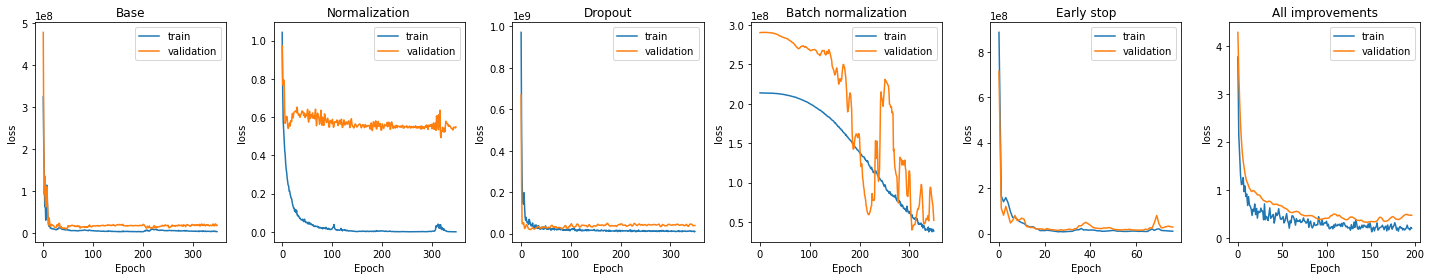

In [106]:
# plot learning curves
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20, 4))
plot_metric(ax1, history_6months, metric="loss", title="Base")
plot_metric(ax2, history_6_norm, metric="loss", title="Normalization")
plot_metric(ax3, history_6_dropout, metric="loss", title="Dropout")
plot_metric(ax4, history_6_batch_norm, metric="loss", title="Batch normalization")
plot_metric(ax5, history_6_early_stop, metric="loss", title="Early stop")
plot_metric(ax6, history_6_all, metric="loss", title="All improvements")
plt.tight_layout()

The graphs plotted above provide a good representation of the models performance in terms of train and validation lost, that can helps us intepret more about the models used. It is important to note that the models vary in performance everytime they are ran, therefore increasing the runs could derive different results. Nevertheless, we will use this as a benchmark.

Both **base** and **dropout** models show signs of overfitting as the validation loss starts to slighty increase its distance from the train line. When the data was **normalized** we can see that the distance between the validation and train loss curves are the biggest. For the **batch normalization** model we can see an extremel noisy validation loss curve, suggesting that the validation dataset does not have sufficient information for the model to generalize on. 

With **all improvements**, we are able to see signs of an unrepresentative training dataset relative to the validation dataset. We will continue to experiment further to understand if increasing the window size will benefit the models. Below, we have also plotted a prediction graph, that shows how far off each model was from the real values when predicting. Suprisingly, the base model seems to obtain the best predictions.

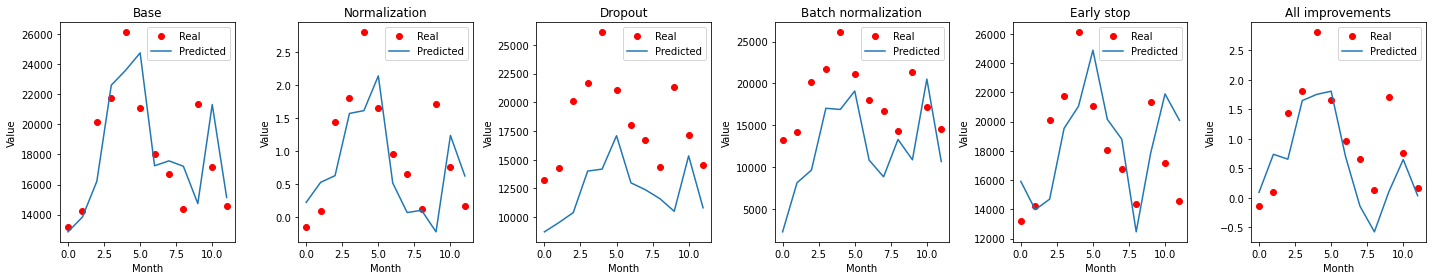

In [108]:
X_mean = X_train.mean()
X_std = X_train.std()

X_train_n = (X_train - X_mean) / X_std
X_val_n = (X_val - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std

y_train_n = (y_train - X_mean) / X_std
y_val_n = (y_val - X_mean) / X_std
y_test_n = (y_test - X_mean) / X_std


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20, 4))
plot_acc(ax1, model_6_base, X_test, y_test, title="Base")
plot_acc(ax2, model_6_norm, X_test_n, y_test_n, title="Normalization")
plot_acc(ax3, model_6_dropout, X_test, y_test, title="Dropout")
plot_acc(ax4, model_6_batch_norm, X_test, y_test, title="Batch normalization")
plot_acc(ax5, model_6_early_stop, X_test, y_test, title="Early stop")
plot_acc(ax6, model_6_all, X_test_n, y_test_n, title="All improvements")
plt.tight_layout()

## 12 months

We will now increase the window size to 12 and perform the same experiment.

In [130]:
X_train, X_val, X_test, y_train, y_val, y_test, n_steps = prepare_data(values, window_size=12, n_val=12, n_test=12);

(72, 12, 1) (12, 12, 1) (12, 12, 1) (72, 1) (12, 1) (12, 1)


In [122]:
print("Base:")
model_12_base, history_12_base = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps)
print("Normalized:")
model_12_norm, history_12_norm = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, normalize=True)
print("Dropout:")
model_12_dropout, history_12_dropout = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, dropout=True)
print("Batch Normalization:")
model_12_batch_norm, history_12_batch_norm = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, batch_norm=True)
print("Early Stop:")
model_12_early_stop, history_12_early_stop = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, early_stop=True)
print("All changes:")
model_12_all, history_12_all = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, normalize=True, dropout=True, batch_norm=True, early_stop=True)

Base:
Average MSE: 6739098.450, Average  RMSE: 2595.977, Average MAE: 1942.775
Normalized:
Average MSE: 0.488, Average  RMSE: 0.699, Average MAE: 0.515
Dropout:
Average MSE: 47818378.000, Average  RMSE: 6915.083, Average MAE: 5858.307
Batch Normalization:
Average MSE: 64176588.800, Average  RMSE: 8011.029, Average MAE: 6383.941
Early Stop:
Average MSE: 21935479.700, Average  RMSE: 4683.533, Average MAE: 3305.816
All changes:
Average MSE: 0.535, Average  RMSE: 0.731, Average MAE: 0.556


As expected, the **normalized** model had the best error results. However - the **early stop** and **dropout** models yielded better results in terms of MSE. The base model, still outperformed on the remaining metrics. Below, we will plot the learning curves to compare the models.

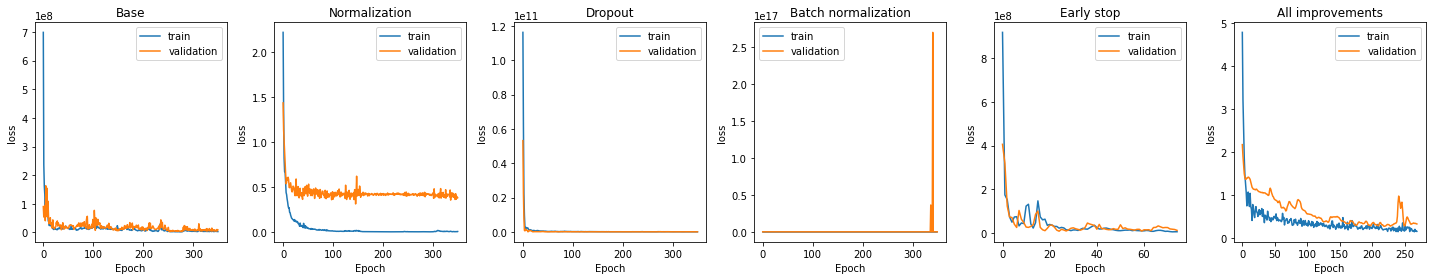

In [123]:
# plot learning curves
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20, 4))
plot_metric(ax1, history_12_base, metric="loss", title="Base")
plot_metric(ax2, history_12_norm, metric="loss", title="Normalization")
plot_metric(ax3, history_12_dropout, metric="loss", title="Dropout")
plot_metric(ax4, history_12_batch_norm, metric="loss", title="Batch normalization")
plot_metric(ax5, history_12_early_stop, metric="loss", title="Early stop")
plot_metric(ax6, history_12_all, metric="loss", title="All improvements")
plt.tight_layout()

With a window size of 12 - the distance between the train and validation loss seemed to decrease in general for all models. It is interesting to note that the **dropout** and **early stop** models showed signs of a good fit. The batch normalization had a strange spike in validation error by the last epochs.

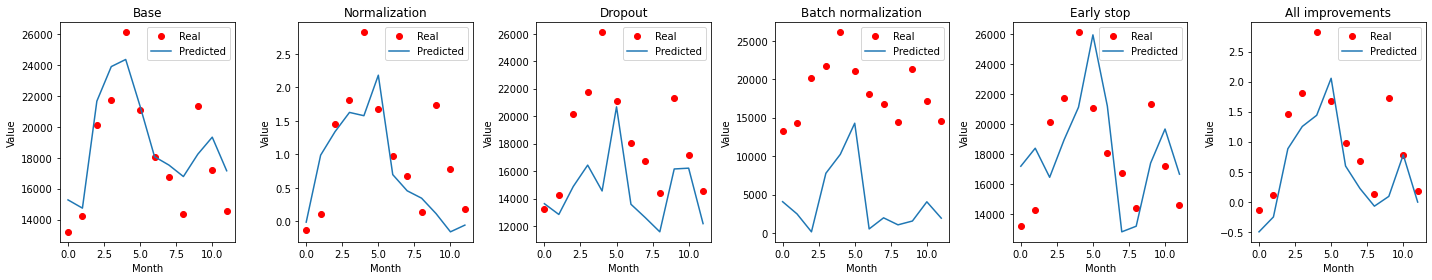

In [132]:
X_mean = X_train.mean()
X_std = X_train.std()

X_train_n = (X_train - X_mean) / X_std
X_val_n = (X_val - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std

y_train_n = (y_train - X_mean) / X_std
y_val_n = (y_val - X_mean) / X_std
y_test_n = (y_test - X_mean) / X_std

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20, 4))
plot_acc(ax1, model_12_base, X_test, y_test, title="Base")
plot_acc(ax2, model_12_norm, X_test_n, y_test_n, title="Normalization")
plot_acc(ax3, model_12_dropout, X_test, y_test, title="Dropout")
plot_acc(ax4, model_12_batch_norm, X_test, y_test, title="Batch normalization")
plot_acc(ax5, model_12_early_stop, X_test, y_test, title="Early stop")
plot_acc(ax6, model_12_all, X_test_n, y_test_n, title="All improvements")
plt.tight_layout()

When looking at the real and predict values graphs - there were not any significant changes.

## Window size: 5 months vs 6 months vs 12 months (base models)

As the base model model showed the best results in terms of prediction, we are going to compare each window size to understand which provides the best results.

In [81]:
def plot_acc(axis, model, X_test, y_test, title):
    axis.set_title(title)
    axis.plot(y_test, 'ro', label="Real")
    axis.plot(model.predict(X_test), label="Predicted")
    axis.set_ylabel('Value')
    axis.set_xlabel('Month')
    axis.legend()

(79, 5, 1) (12, 5, 1) (12, 5, 1) (79, 1) (12, 1) (12, 1)
(78, 6, 1) (12, 6, 1) (12, 6, 1) (78, 1) (12, 1) (12, 1)
(72, 12, 1) (12, 12, 1) (12, 12, 1) (72, 1) (12, 1) (12, 1)


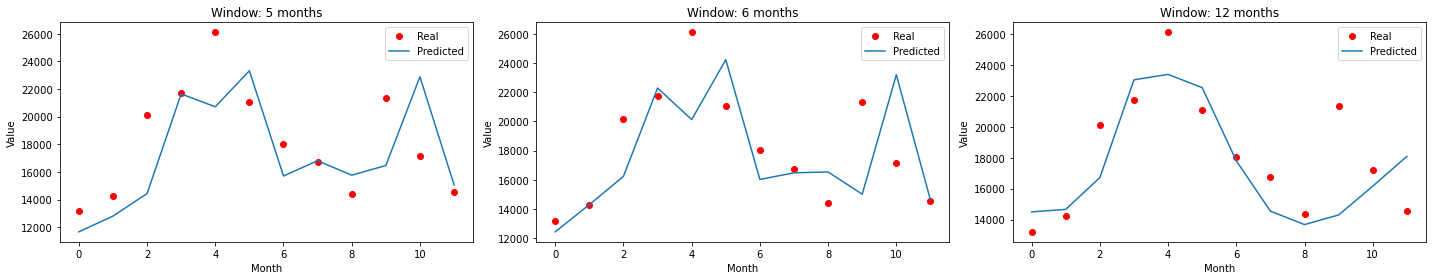

In [85]:
X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5, n_steps = prepare_data(values, window_size=5, n_val=12, n_test=12);
X_train_6, X_val_6, X_test_6, y_train_6, y_val_6, y_test_6, n_steps = prepare_data(values, window_size=6, n_val=12, n_test=12);
X_train_12, X_val_12, X_test_12, y_train_12, y_val_12, y_test_12, n_steps = prepare_data(values, window_size=12, n_val=12, n_test=12);

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 4))
plot_acc(ax1, model_base, X_test_5, y_test_5, title="Window: 5 months")
plot_acc(ax2, model_6_base, X_test_6, y_test_6, title="Window: 6 months")
plot_acc(ax3, model_12_base, X_test_12, y_test_12, title="Window: 12 months")
plt.tight_layout()

It seems that a window of 12 months provided the best results as the predicted values are more consistent throught the months. In particular, the 12 month window size takes into better consideration the spike on month 4.

# Multi-step

Previously, as per the tutorial we have been experiment with sequences that only predict 1 output. In this final section, we are going to experiment so that the number of predicted outputs is equal to 3.

In [125]:
X_train, X_val, X_test, y_train, y_val, y_test, n_steps = prepare_data(values, window_size=6, n_predicted=3, n_val=12, n_test=12);

(76, 6, 1) (12, 6, 1) (12, 6, 1) (76, 3) (12, 3) (12, 3)


In [126]:
print("Base:")
multi_model_6_base, multi_history_6_base = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=3)
print("Normalized:")
multi_model_6_norm, multi_history_6_norm = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=3, normalize=True)
print("Dropout:")
multi_model_6_dropout, multi_history_6_dropout = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=3, dropout=True)
print("Batch Normalization:")
multi_model_6_batch_norm, multi_history_6_batch_norm = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=3, batch_norm=True)
print("Early Stop:")
multi_model_6_early_stop, multi_history_6_early_stop = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=3, early_stop=True)
print("All changes:")
multi_model_6_all, multi_history_6_all = create_model(X_train, X_val, X_test, y_train, y_val, y_test, n_steps, n_predicted=3, normalize=True, dropout=True, batch_norm=True, early_stop=True)

Base:
Average MSE: 17256279.800, Average  RMSE: 4154.068, Average MAE: 3284.117
Normalized:
Average MSE: 0.746, Average  RMSE: 0.864, Average MAE: 0.687
Dropout:
Average MSE: 52241882.400, Average  RMSE: 7227.855, Average MAE: 5957.285
Batch Normalization:
Average MSE: 134227966.400, Average  RMSE: 11585.679, Average MAE: 10283.914
Early Stop:
Average MSE: 19836462.400, Average  RMSE: 4453.814, Average MAE: 3613.202
All changes:
Average MSE: 0.526, Average  RMSE: 0.725, Average MAE: 0.549


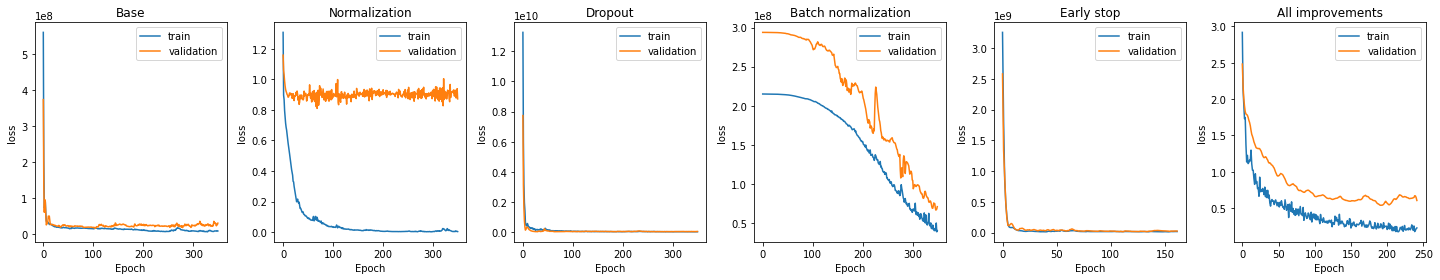

In [127]:
# plot learning curves
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=(20, 4))
plot_metric(ax1, multi_history_6_base, metric="loss", title="Base")
plot_metric(ax2, multi_history_6_norm, metric="loss", title="Normalization")
plot_metric(ax3, multi_history_6_dropout, metric="loss", title="Dropout")
plot_metric(ax4, multi_history_6_batch_norm, metric="loss", title="Batch normalization")
plot_metric(ax5, multi_history_6_early_stop, metric="loss", title="Early stop")
plot_metric(ax6, multi_history_6_all, metric="loss", title="All improvements")
plt.tight_layout()

In [128]:
row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0, 13354.0]).reshape((1, n_steps, 1))
yhat = multi_model_6_base.predict(row)
print('Predicted (following 3 months): ' + str(yhat))

Predicted (following 3 months): [[12747.033 11927.885 16127.92 ]]


## Conclusion

Overall the models behaved differently and there was not a clear manner of understanding which behaved best. For predictions it was clear that giving a higher window meant that the model could better understand and learn the sequences. We also understood that while, the base model showed the most consistent results - early stopping a good way to reduce overfitting and execution time. However, it would have been nice to experiment with different patience levels to understand its impact on the model. Pre-processing the data by normalizing it in this case had negative impacts on the overall performance of the model.